## This notebook contains code to create the supplementary figures shown in "Hot extremes have become drier in the US Southwest" by Karen A. McKinnon, Andrew Poppick, and Isla R. Simpson

Note that you should first run the NCC_figs notebook, because this notebook draws upon some of the calculations in that notebook.

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
from glob import glob
import os
import calendar

import statsmodels.api as sm
from scipy.spatial import distance_matrix, Voronoi, voronoi_plot_2d, ConvexHull
from scipy.stats import spearmanr, pearsonr
import scipy.special as special
from scipy.signal import detrend

from compound_extremes import utils
from humidity_variability.utils import add_date_columns
from helpful_utilities.general import lowpass_butter

import geopandas
import salem
from shapely.geometry import shape, Point
import geojson

import matplotlib.gridspec as gridspec
from matplotlib import colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
start_year = 1973  # for ISD1973, or 1950 for ISD1950
end_year = 2019
start_month = 7
end_month = 9
datatype = 'ISD'
predictor_name = 'GMT'  # 'year' or 'GMT'. Published analysis uses GMT.
grouping = 'year'
humidity_var = 'Q'
temp_var = 'TMP'
qs = np.array([0.05, 0.1, 0.5, 0.9, 0.95])
percentile_cutoff = 33  # for ERA5 composites

# This folder contains the ISD station data
datadir = '/glade/work/mckinnon/ISD/csv'

# This folder contains files such as
# ISD_US_extremes_params_trend_GMT_1973_2019_month_7-9_*.npz
# which contains the fitted parameters from the quantile smoothing splines model for each station
paramdir = '/glade/work/mckinnon/ISD/csv/params'

# This folder contains the folders ERA5 and JRA55, which have the parameter fits for those reanalyses
reanalysis_base_dir = '/glade/work/mckinnon'

# This folder is used to save pre-processed files used for the figures
fdir = '/glade/work/mckinnon/dry_west/processed_data'

# and figures will be saved here
figdir = '/glade/u/home/mckinnon/compound_extremes/compound_extremes/figs'

# This folder should contain the sub-daily values from ERA5
daily_ERA_dir = '/glade/work/mckinnon/ERA5/day'

# This folder contains the monthly values from ERA5
era5_dir = '/glade/work/mckinnon/ERA5/month'

# This folder contains the CMIP6 model output
cmip6_dir = '/glade/scratch/mckinnon/cmip6'

# GPCC precipitation (https://psl.noaa.gov/data/gridded/data.gpcc.html)
gpcc_fname = '/glade/work/mckinnon/GPCC/precip.comb.v2018to2016-v6monitorafter.total.nc'

# open metadata
metadata = pd.read_csv('%s/new_metadata.csv' % datadir)
station_id = ['%06d-%05d' % (row['usaf'], row['wban']) for _, row in metadata.iterrows()]
metadata = metadata.assign(station_id=station_id)

fit_data_ISD = '%s/ISD_US_map_data_trend_%s_%i_%i_month_%i-%i.npz' % (fdir, predictor_name, 
                                                                      start_year, end_year,
                                                                      start_month, end_month)

In [4]:
save_df = '%s/western_data_ISD_%04d_%04d_month_%i-%i.csv' % (fdir, start_year, end_year, start_month, end_month)
save_meta = '%s/western_meta_ISD_%04d_%04d_month_%i-%i.csv' % (fdir, start_year, end_year, start_month, end_month)

western_df = pd.read_csv(save_df)
western_meta = pd.read_csv(save_meta)  

# Get rid of extra columns
western_meta = western_meta.loc[:, np.isin(western_meta.columns, western_meta.columns[4:])]
western_df = western_df.loc[:, np.isin(western_df.columns, western_df.columns[2:])]

station_ds = np.load(fit_data_ISD)
all_station_lat = station_ds['lats']
all_station_lon = station_ds['lons']
all_station_lat = np.round(all_station_lat, decimals=3)
all_station_lon = np.round(all_station_lon, decimals=3)

def voronoi_volumes(points):
    v = Voronoi(points)
    vol = np.zeros(v.npoints)
    for i, reg_num in enumerate(v.point_region):
        indices = v.regions[reg_num]
        if -1 in indices: # some regions can be opened
            vol[i] = np.inf
        else:
            vol[i] = ConvexHull(v.vertices[indices]).volume
    return vol

vol = voronoi_volumes(np.vstack((all_station_lon, all_station_lat)).T)

# Add Voronoi volumes to metadata
area_weights = np.nan*np.ones(len(western_meta))
for ct, row in western_meta.iterrows():
    # find matching lat index
    this_lat = np.round(row['lat'], decimals=3)
    this_lon = np.round(row['lon'], decimals=3)
    match_idx = (all_station_lat == this_lat) & (all_station_lon == this_lon)
    area_weights[ct] = vol[match_idx]

# in both cases, one outlier, set to max
sorted_vals = np.sort(area_weights)
area_weights[np.argmax(area_weights)] = sorted_vals[-2]

western_meta = western_meta.assign(area_weights=area_weights)

In [5]:
# for maps
central_lat = 37.5
central_lon = -96
extent = [-120, -70, 21, 50.5]
central_lon = np.mean(extent[:2])
central_lat = np.mean(extent[2:])

# ROI
gjson_fname_west = '../shapefiles/interior_west.json'
interior_west = geopandas.read_file(gjson_fname_west)

lon_range = (np.min(interior_west['geometry'][0].exterior.coords.xy[0]), 
             np.max(interior_west['geometry'][0].exterior.coords.xy[0]))
lat_range = (np.min(interior_west['geometry'][0].exterior.coords.xy[1]), 
             np.max(interior_west['geometry'][0].exterior.coords.xy[1]))

with open(gjson_fname_west) as f:
    geo = geojson.load(f)
    interior_west_shapely = shape(geo[0]['geometry'])

In [6]:
def sel_season(month, month_start, month_end):
    return (month >= month_start) & (month <= month_end)

### Load amplification index for future use

In [7]:
# Load all amplification indices
for data_name in list(('ISD_1973', 'ISD_1950', 'JRA55', 'ERA5')):
    if data_name == 'JRA55':
        this_start_year = 1958
    elif data_name == 'ERA5':
        this_start_year = 1979
    else:
        this_start_year = int(data_name[4:])

    savename = '%s/%s_amplification_%s_%i_%i_month_%i-%i.npz' % (fdir, data_name.split('_')[0], grouping, 
                                                                 this_start_year, end_year,
                                                                 start_month, end_month)
    all_years = np.arange(1950, 2020)
    nmissing = this_start_year - 1950
    nan_pad = np.nan*np.ones((nmissing, ))
    if data_name == 'JRA55':
        amplification_JRA55 = np.load(savename)['amplification']
        
        amplification_JRA55 = pd.DataFrame({'year': all_years, 
                                            'JRA55': np.hstack((nan_pad, amplification_JRA55))})
        amplification_JRA55 = amplification_JRA55.set_index('year')
    elif data_name == 'ERA5':
        amplification_ERA5 = np.load(savename)['amplification']
        amplification_ERA5 = pd.DataFrame({'year': all_years, 
                                           'ERA5': np.hstack((nan_pad, amplification_ERA5))})
        amplification_ERA5 = amplification_ERA5.set_index('year')
    elif data_name == 'ISD_1973':
        amplification_ISD1973 = np.load(savename)['amplification']
        amplification_ISD1973 = pd.DataFrame({'year': all_years, 
                                              'ISD1973': np.hstack((nan_pad, amplification_ISD1973))})
        amplification_ISD1973 = amplification_ISD1973.set_index('year')
    elif data_name == 'ISD_1950':
        amplification_ISD1950 = np.load(savename)['amplification']
        amplification_ISD1950 = pd.DataFrame({'year': all_years, 
                                              'ISD1950': amplification_ISD1950})
        amplification_ISD1950 = amplification_ISD1950.set_index('year')

amplification_all = pd.concat([amplification_ERA5, amplification_ISD1950, 
                               amplification_ISD1973, amplification_JRA55], 
                              axis=1)

amplification_avg = amplification_all.mean(axis=1)

### Load time series of relevant modes and GMTA


In [8]:
# Load annual mean GMT and AMV, and low-pass filter
lowpass_freq = 1/10

## Get GMTA (via http://berkeleyearth.lbl.gov/auto/Global/Land_and_Ocean_complete.txt)
GMT_fname = '../data/Land_and_Ocean_complete.txt'
gmt_data = pd.read_csv(GMT_fname, comment='%', header=None, delim_whitespace=True).loc[:, :2]
gmt_data.columns = ['year', 'month', 'GMTA']

# drop the second half, which infers sea ice T from water temperature
stop_idx = np.where(gmt_data['year'] == gmt_data['year'][0])[0][12] - 1
gmt_data = gmt_data.loc[:stop_idx, :]

# remove last year (not complete)
gmt_data = gmt_data[gmt_data['year'] < np.max(gmt_data['year'])]

# Perform lowpass filtering
gmt_smooth = lowpass_butter(12, lowpass_freq, 3, gmt_data['GMTA'].values)
gmt = gmt_data.assign(GMTA=gmt_smooth)

# take annual average
gmt = gmt.groupby('year').mean()
gmt = gmt.drop(columns=['month'])

# Pull out range of GMTA over the primary period of analysis
# gmt_short = gmt[(gmt.index >= 1973) & (gmt.index <= 2019)]
# gmt_short = gmt_short - np.mean(gmt_short)
# G_range = np.max(gmt_short.values) - np.min(gmt_short.values)

## Get AMV, calculated with CVDP on ERSSTv5 data
amv_file = '../data/amo_monthly_ERSSTv5_1854_2020.nc'
da_amv = xr.open_dataarray(amv_file)
amo = da_amv.mean('mon')
amo = amo.sel(year=slice(1854, 2019))
amo = amo.assign_coords(year=amo.year.astype(int))
amo_10yr = lowpass_butter(1, lowpass_freq, 3, amo.values)
amo.values = amo_10yr
amo = amo.to_dataframe()

## Get PDO (via )
pdo_file = '../data/pdo_ncei.csv'
pdo = pd.read_csv(pdo_file, header=1)
# change date to get year and month
pdo_year = np.array([int((str(d))[:4]) for d in pdo['Date']])
pdo_month = np.array([int((str(d))[4:]) for d in pdo['Date']])
pdo = pdo.assign(year=pdo_year)
pdo = pdo.assign(month=pdo_month)
pdo = pdo.groupby('year').mean()['Value']

## Get ENSO (via https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt)
enso_file = '../data/enso_ncei.txt'
enso = pd.read_csv(enso_file, delim_whitespace=True)
enso = enso.rename(columns={'YR': 'year'})
enso = enso.set_index('year')
enso = enso[enso['SEAS']=='DJF']['ANOM']

### Supplementary figure 6: anomaly calculation

Demonstrate different methods for calculating anomalies on ISD data, using a station with a monsoon as an example

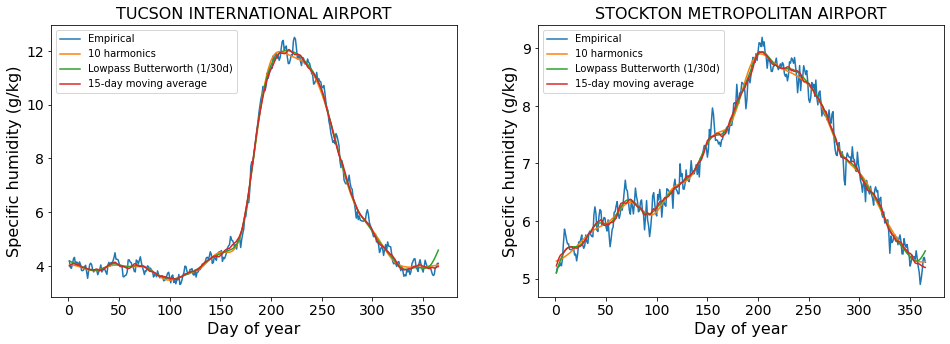

In [33]:
stations_plot = '722740-23160', '724920-23237' 
stations_names = 'TUCSON INTERNATIONAL AIRPORT', 'STOCKTON METROPOLITAN AIRPORT'

fig, ax = plt.subplots(figsize=(16, 5), ncols=2)

for ct, this_station in enumerate(stations_plot):
    df = pd.read_csv('%s/%s.csv' % (datadir, this_station))

    df = df[~np.isnan(df[humidity_var])]
    df = df[~np.isnan(df[temp_var])]

    # Reset index, then get rid of the extra column
    df = df.reset_index()
    df = df.drop(columns=[df.columns[0]])

    df = add_date_columns(df)

    # empirical seasonal cycle
    empirical_sc = df.groupby('doy').mean()['Q'][:365]

    # fit with 10 fourier bases
    nbases = 10
    _, _, seasonal_fit_fourier = utils.fit_seasonal_cycle(df['doy'], df['Q'].copy(), nbases=nbases)

    # fit with lowpass filter (1/30day cutoff)
    cut = 1/30
    _, _, seasonal_fit_butter = utils.fit_seasonal_cycle_lowpass(df['doy'], df['Q'].copy(), cut_freq=cut)

    # simple moving average
    ts_repeat = np.hstack((empirical_sc, empirical_sc, empirical_sc))
    w = 15
    mask = np.ones((1,w))/w
    mask = mask[0, :]
    seasonal_fit_MA = np.convolve(ts_repeat, mask, 'same')[365:(365*2)]

    # Plot data as empirical average as a function of doy
    ax[ct].plot(np.arange(1, 366), empirical_sc, label='Empirical')
    ax[ct].plot(np.arange(1, 366), seasonal_fit_fourier, label='%i harmonics' % nbases)
    ax[ct].plot(np.arange(1, 366), seasonal_fit_butter[:365], label='Lowpass Butterworth (1/30d)')
    ax[ct].plot(np.arange(1, 366), seasonal_fit_MA, label='%i-day moving average' % w)
    ax[ct].legend()
    ax[ct].set_title(stations_names[ct], fontsize=16)
    ax[ct].set_xlabel('Day of year', fontsize=16)
    ax[ct].set_ylabel('Specific humidity (g/kg)', fontsize=16)
    ax[ct].tick_params(labelsize=14)
    
plt.savefig('%s/supp_fig_seasonal_fit.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 1: Spearman rank correlation map

In [10]:
rho_savename = '%s/ERA5_corr_spearman.nc' % fdir
savename = '%s/proc_T_US.nc' % fdir

if not os.path.isfile(rho_savename):
    
    if not os.path.isfile(savename):

        f_Td = '/glade/work/mckinnon/ERA5/day/Td/ERA5_Td_US.nc'
        f_T = '/glade/work/mckinnon/ERA5/day/2mT/ERA5_2mT_US.nc'
        f_p = '/glade/work/mckinnon/ERA5/day/p/ERA5_p_US.nc'

        da_Td = xr.open_dataarray(f_Td)  # K
        da_T = xr.open_dataarray(f_T)  # K
        da_p = xr.open_dataarray(f_p)  # Pa

        # Calculate q
        e = 6.112*np.exp((17.67*(da_Td - 273.15))/((da_Td - 273.15) + 243.5))
        da_q =  1000*(0.622 * e)/((da_p/100) - (0.378 * e))  # g/kg

        del da_p, da_Td, e

        # Calculate daily averages
        da_T = da_T.resample(time='D').mean()
        da_q = da_q.resample(time='D').mean()
        
        # Remove seasonal cycle in temperature
        nbases = 3
        data = da_T.values
        nt, nlat, nlon = data.shape
        data_vec = data.reshape((nt, nlat*nlon))
        mu = np.mean(data_vec, axis=0)
        doy = da_T['time.dayofyear']
        t_basis = (doy - 0.5)/365
        bases = np.empty((nbases, nt), dtype=complex)
        for counter in range(nbases):
            bases[counter, :] = np.exp(2*(counter + 1)*np.pi*1j*t_basis)

        coeff = 2/nt*(np.dot(bases, data_vec))
        rec = np.real(np.dot(bases.T, np.conj(coeff)))
        residual_T = data_vec - rec - mu
        
        # Remove seasonal cycle in humidity
        nbases = 10
        data = da_q.values
        nt, nlat, nlon = data.shape
        data_vec = data.reshape((nt, nlat*nlon))
        mu = np.mean(data_vec, axis=0)
        doy = da_q['time.dayofyear']
        t_basis = (doy - 0.5)/365
        bases = np.empty((nbases, nt), dtype=complex)
        for counter in range(nbases):
            bases[counter, :] = np.exp(2*(counter + 1)*np.pi*1j*t_basis)

        coeff = 2/nt*(np.dot(bases, data_vec))
        rec = np.real(np.dot(bases.T, np.conj(coeff)))
        residual_H = (data_vec - rec - mu).reshape((nt, nlat, nlon))
        
        da_T_anom = da_T.copy(data=residual_T)
        da_q_anom = da_q.copy(data=residual_H)

        # Drop anything outside of summer
        da_T_anom = da_T_anom.sel(time=((da_T_anom['time.month'] >= start_month) & 
                                        (da_T_anom['time.month'] <= end_month)))
        da_q_anom = da_q_anom.sel(time=((da_q_anom['time.month'] >= start_month) & 
                                        (da_q_anom['time.month'] <= end_month)))

        # Save processed data
        da_T_anom.to_netcdf(savename)
        da_q_anom.to_netcdf('%s/proc_q_US.nc' % fdir)
        
    else:
        da_T_anom = xr.open_dataarray(savename)
        da_q_anom = xr.open_dataarray('%s/proc_q_US.nc' % fdir)

    # Correlation
    ntime, nlat, nlon = da_T_anom.shape

    rho = np.empty((nlat, nlon))

    for ii in range(nlat):
        for jj in range(nlon):
            rho[ii, jj] = spearmanr(da_T_anom[:, ii, jj].values, da_q_anom[:, ii, jj].values)[0]

    da_rho = xr.DataArray(rho, dims=['latitude', 'longitude'], coords=[da_T_anom.latitude, da_T_anom.longitude])
    da_rho.to_netcdf(rho_savename)

else:
    da_rho = xr.open_dataarray(rho_savename)

In [11]:
stations_plot = ['724645-23070', '723890-93193']
# get lats, lons
lats_plot = []
lons_plot = []

for s in stations_plot:
    lats_plot.append(western_meta.loc[western_meta['station_id'] == s, 'lat'].values[0])
    lons_plot.append(western_meta.loc[western_meta['station_id'] == s, 'lon'].values[0])
    

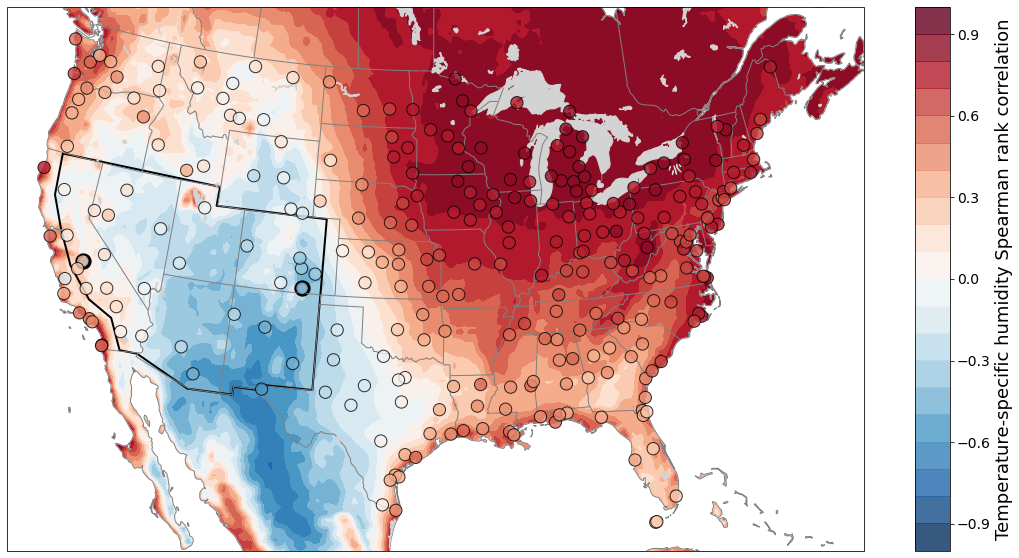

In [12]:
datatype = 'ISD'
predictor_name = 'GMT'
fit_data = '%s/%s_US_map_data_trend_%s_%i_%i_month_%i-%i.npz' % (fdir, datatype, predictor_name, 
                                                                 1973, end_year,
                                                                 start_month, end_month)

ds_ISD = np.load(fit_data)
lats_ISD = ds_ISD['lats']
lons_ISD = ds_ISD['lons']
rho_ISD = ds_ISD['rho']

to_plot = da_rho

fig = plt.figure(figsize=(17, 10))
widths = [10, 0.4]
spec = fig.add_gridspec(ncols=2, nrows=1, 
                        width_ratios=widths)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

# Add the map and set the extent
ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_map.set_extent(extent)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.LAND, color='lightgray')
ax_map.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=2)
ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=2)
ax_map.add_feature(cfeature.LAKES, color='lightgray', zorder=2)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=2)
ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=2)

cmap = plt.cm.RdBu_r
bounds = np.arange(-1, 1.1, 0.1)
norm = colors.BoundaryNorm(bounds, cmap.N)

da_rho.plot.contourf(ax=ax_map, 
                     transform=ccrs.PlateCarree(),
                     cmap=cmap,
                     levels=bounds,
                     add_colorbar=False,
                     zorder=1)

ax_map.scatter(lons_plot,
                lats_plot,
                c=None,
                transform=ccrs.PlateCarree(),
                s=150,
                edgecolor='k',
              lw=4)

sc = ax_map.scatter(lons_ISD,
                    lats_ISD,
                    c=rho_ISD,
                    transform=ccrs.PlateCarree(),
                    s=150,
                    cmap=cmap,
                    norm=norm,
                    alpha=0.8,
                    zorder=3,
                    edgecolor='k')



cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='neither')
cb.ax.tick_params(labelsize=14) 

cb.set_label('Temperature-specific humidity Spearman rank correlation', fontsize=18)

plt.savefig('%s/supp_fig_spearman_corr.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 4: CMIP6 biases

Histograms of mean state in CMIP6 vs ERA5 for historical period

In [13]:
def preprocess_monthly_netcdf_cmip6(fnames, this_var, month1, month2):
    
    """Get time series of seasonal averages of a given variable in the Southwest."""
    
    # Load files
    ds = xr.open_mfdataset(fnames, combine='nested', concat_dim='time', chunks={'time': -1})
    da = ds[this_var]

    # Subset to month range
    da = da.sel(time=((da['time.month'] >= month1) & (da['time.month'] <= month2)))
    
    # take annual average
    da = da.groupby('time.year').mean()
    
    da = da.sel(year=slice('1979', '2014'))  # for comparison with ERA5

    # change longitude
    da = da.assign_coords(lon=(((da.lon + 180) % 360) - 180))
    da = da.sortby('lon')
    
    # Subset to west (approx)
    da = da.sel(lat=slice(lat_range[0], lat_range[1]),
                lon=slice(lon_range[0], lon_range[1]))

    # Create time series, area-weighted
    nlon = len(da.lon)
    area_weights = np.cos(np.deg2rad(da.lat)).values
    area_weights = np.repeat(area_weights[:, np.newaxis], nlon, axis=-1)
    da = da.to_dataset(name=this_var)
    da = da.assign({'weights' : (('lat', 'lon'), area_weights)})
    da = da.salem.roi(geometry=interior_west_shapely, crs='wgs84')

    ts = ((da[this_var]*da.weights).sum(['lat', 'lon'])/
          da.weights.sum(['lat', 'lon']))
    
    return ts

In [14]:
varnames = 'mrsos', 'mrso', 'pr', 'hfls'
exp_name = 'historical'
this_cmip6_dir = '%s/%s' % (cmip6_dir, exp_name)
for var_name in varnames:
    print(var_name)
    if var_name == 'mrso': 
        month1 = 6
        month2 = 6
    else:
        month1 = 7
        month2 = 9
        
    savename = '%s/%s_%i-%i_%s_ERA5period.nc' % (fdir, var_name, month1, month2, exp_name)
    if not os.path.isfile(savename):

        modelnames = sorted(glob('%s/%s/*' % (this_cmip6_dir, var_name)))
        modelnames = [m.split('/')[-1] for m in modelnames]
        if 'MCM-UA-1-0' in modelnames:
            modelnames.remove('MCM-UA-1-0')

        da_list = []
        N = np.nan*np.ones(len(modelnames))

        for ct, this_model in enumerate(modelnames):
            print(this_model)

            these_files = sorted(glob('%s/%s/%s/*/*/*.nc' % (this_cmip6_dir, var_name, this_model)))

            # Get files for each ensemble member
            em_member_names = sorted(np.unique([f.split('/')[8] for f in these_files]))
            ts_single_model = []
            for em_member_use in em_member_names:

                these_files = sorted(glob('%s/%s/%s/%s/*/*.nc' % (this_cmip6_dir, var_name, 
                                                                  this_model, em_member_use)))


                if 'ssp' in exp_name:
                    if len(these_files) > 1:
                        start_year = np.array([int(f.split('/')[-1].split('_')[-1].split('.')[0].split('-')[0]) 
                                               for f in these_files])
                        too_late = start_year > 210100
                        if too_late.any():
                            these_files = these_files[:np.where(too_late)[0][0]]
                N[ct] = len(these_files)
                ts = preprocess_monthly_netcdf_cmip6(these_files, var_name, month1, month2)
            
                ts_single_model.append(ts.load())
                del ts

            ts = xr.concat(ts_single_model, dim='member')
            ts = ts.mean('member')  # get EM of each model
            da_list.append(ts)

        da = xr.concat(da_list, dim='model', coords='minimal', compat='override')
        da = da.assign_coords(model=modelnames)

        da.to_netcdf('%s/%s_%i-%i_%s_ERA5period.nc' % (fdir, var_name, month1, month2, exp_name))
        np.save('%s/%s_%i-%i_%s_N_ERA5period.npy' % (fdir, var_name, month1, month2, exp_name), N)

mrsos
mrso
pr
hfls


In [15]:
# Load CMIP values, compare to ERA values
L = 2.5e6  # J/kg
cmip_pr = xr.open_dataarray('%s/pr_7-9_historical_ERA5period.nc' % fdir)
cmip_pr *= 24*60*60   # change from /sec to /day
cmip_mrsos = xr.open_dataarray('%s/mrsos_7-9_historical_ERA5period.nc' % fdir)
cmip_hfls = xr.open_dataarray('%s/hfls_7-9_historical_ERA5period.nc' % fdir)
cmip_evap = ((cmip_hfls/L)*24*60*60)  # mm/day

In [16]:
gpcc_pr = pd.read_csv('%s/precip_ts_month_7-9.csv' % fdir)
gpcc_pr['precip'] /= ((31 + 31 + 30)/3)  # change from /month to /day
era5_evap = pd.read_csv('%s/e_ts_month_7-9.csv' % fdir)
era5_evap['e'] *= (1000)  # change to mm
era5_mrsos = pd.read_csv('%s/swvl1_ts_month_7-9.csv' % fdir)
era5_mrsos['swvl1'] *= (1000*10/7)  # change to mm, scale to top 10cm (ERA5 is top 7cm)

In [17]:
ntime = len(gpcc_pr)
N = 1000
boot_mean_pr = np.empty((N, ))
boot_mean_evap = np.empty((N, ))
boot_mean_mrsos = np.empty((N, ))
for kk in range(N):
    boot_mean_pr[kk] = gpcc_pr.iloc[np.random.choice(np.arange(ntime), ntime)].mean()['precip']
    boot_mean_evap[kk] = era5_evap.iloc[np.random.choice(np.arange(ntime), ntime)].mean()['e']
    boot_mean_mrsos[kk] = era5_mrsos.iloc[np.random.choice(np.arange(ntime), ntime)].mean()['swvl1']

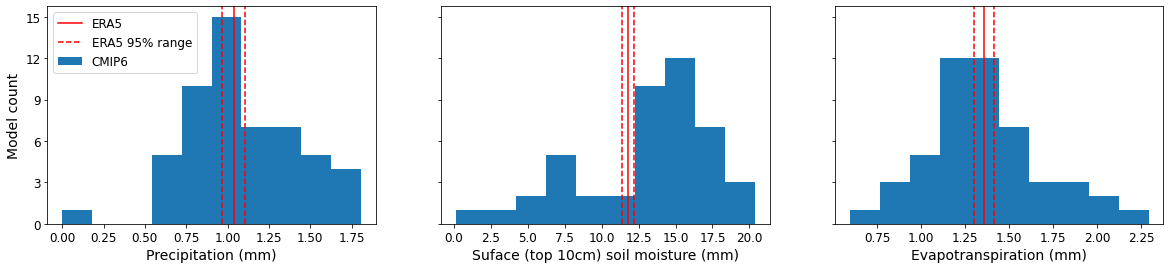

In [31]:
fig, ax = plt.subplots(figsize=(20, 4), ncols=3, sharey=True)
ax[0].hist(cmip_pr.mean('year'), label='CMIP6')
ax[0].axvline(gpcc_pr['precip'].mean(), color='red', label='ERA5')
ax[0].axvline(np.percentile(boot_mean_pr, 2.5), color='red', ls='--')
ax[0].axvline(np.percentile(boot_mean_pr, 97.5), color='red', ls='--', label='ERA5 95% range')
ax[0].set_xlabel('Precipitation (mm)', fontsize=14)
ax[0].legend(loc='upper left', fontsize=12)

ax[1].hist(cmip_mrsos.mean('year'))
ax[1].axvline(era5_mrsos['swvl1'].mean(), color='red') 
ax[1].axvline(np.percentile(boot_mean_mrsos, 2.5), color='red', ls='--')
ax[1].axvline(np.percentile(boot_mean_mrsos, 97.5), color='red', ls='--')
ax[1].set_xlabel('Suface (top 10cm) soil moisture (mm)', fontsize=14)

ax[2].hist(cmip_evap.mean('year'))
ax[2].axvline(era5_evap['e'].mean(), color='red')  
ax[2].axvline(np.percentile(boot_mean_evap, 2.5), color='red', ls='--')
ax[2].axvline(np.percentile(boot_mean_evap, 97.5), color='red', ls='--')
ax[2].set_xlabel('Evapotranspiration (mm)', fontsize=14)

for a in ax:
    a.tick_params(labelsize=12)
ax[0].set_yticks(np.arange(0, 16, 3))

ax[0].set_ylabel('Model count', fontsize=14)

plt.savefig('%s/supp_fig_cmip6_hist.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 2a: vertical profile for ERA5

Note that the other components of Supplementary figure 2, and Supplementary figure 3, are produced in the main notebook. 

/glade/work/mckinnon/venvs/humidity/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


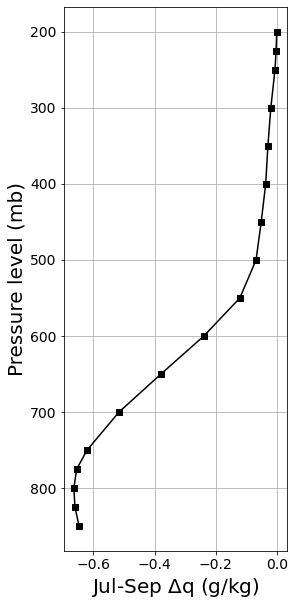

In [19]:
# Calculate average geopotential height over southwest to decide where to composite q vertically
ds_oro = xr.open_dataset('/glade/work/mckinnon/ERA5/time_invariant/orography_lsmask.nc')
da_oro = ds_oro['z'].squeeze()
del ds_oro

# subset to domain
da_oro = da_oro.sel(latitude=slice(55, 20), longitude=slice(230, 300))
da_oro = da_oro.assign_coords(longitude=(((da_oro.longitude + 180) % 360) - 180))
da_oro = da_oro.sortby('latitude')
da_oro = da_oro.salem.roi(geometry=interior_west_shapely, crs='wgs84')

# Load geopotential height to get mask
ds_z = xr.open_dataset('/glade/work/mckinnon/ERA5/month/z/era5_z.nc')
da_z = ds_z['z']

# Downloaded data is already around US only
da_z = da_z.sortby('latitude')
da_z = da_z.salem.roi(geometry=interior_west_shapely, crs='wgs84')

below_surface = da_z.mean('time') < da_oro

# Load q
ds_q = xr.open_dataset('/glade/work/mckinnon/ERA5/month/q/era5_q.nc')
da_q = ds_q['q']
da_q = da_q.sortby('latitude')
da_q = da_q.salem.roi(geometry=interior_west_shapely, crs='wgs84')
da_q = da_q.where(~below_surface)

# Make time series of vertical profiles
da_q_vert = da_q.mean(['latitude', 'longitude'])

fig, ax = plt.subplots(figsize=(4, 10))

month_start = 7
month_end = 9

da_anom = da_q_vert.sel(time=sel_season(da_q_vert['time.month'], month_start, month_end))
da_anom = da_anom.groupby('time.year').mean()

da_anom = da_anom.sel(year=da_anom['year'] <= 2019)

era_ts = amplification_ERA5[~np.isnan(amplification_ERA5['ERA5'])].copy(deep=True)

top_idx = era_ts > np.percentile(era_ts, 100 - percentile_cutoff)
bottom_idx = era_ts < np.percentile(era_ts, percentile_cutoff)

top_years = era_ts.index.values[top_idx.values.flatten()]
bottom_years = era_ts.index.values[bottom_idx.values.flatten()]

da_top = da_anom.sel(year=np.isin(da_anom['year'], top_years)).mean('year')
da_bottom = da_anom.sel(year=np.isin(da_anom['year'], bottom_years)).mean('year')

da_delta = (da_top - da_bottom)

# Plot absolute and fractional difference

(1e3*(da_top - da_bottom)).plot.line('-sk', y='level', 
                                     yincrease=False, ax=ax)

ax.tick_params(labelsize=14)
ax.set_ylabel('Pressure level (mb)', fontsize=20)
ax.set_xlabel(r'%s-%s $\Delta$q (g/kg)' % (calendar.month_abbr[month_start], 
                                           calendar.month_abbr[month_end]), fontsize=20)
ax.grid()

plt.savefig('%s/supp_fig_vertical_profile.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 5: a la Fig 2 but for ISD1950

In [20]:
ISD1950_fit = '%s/ISD_US_map_data_trend_GMT_1950_2019_month_7-9.npz' % fdir
ERA5_fit = '%s/ERA5_US_map_data_trend_GMT_1979_2019_month_7-9.npz' % fdir
JRA55_fit = '%s/JRA55_US_map_data_trend_GMT_1958_2019_month_7-9.npz' % fdir

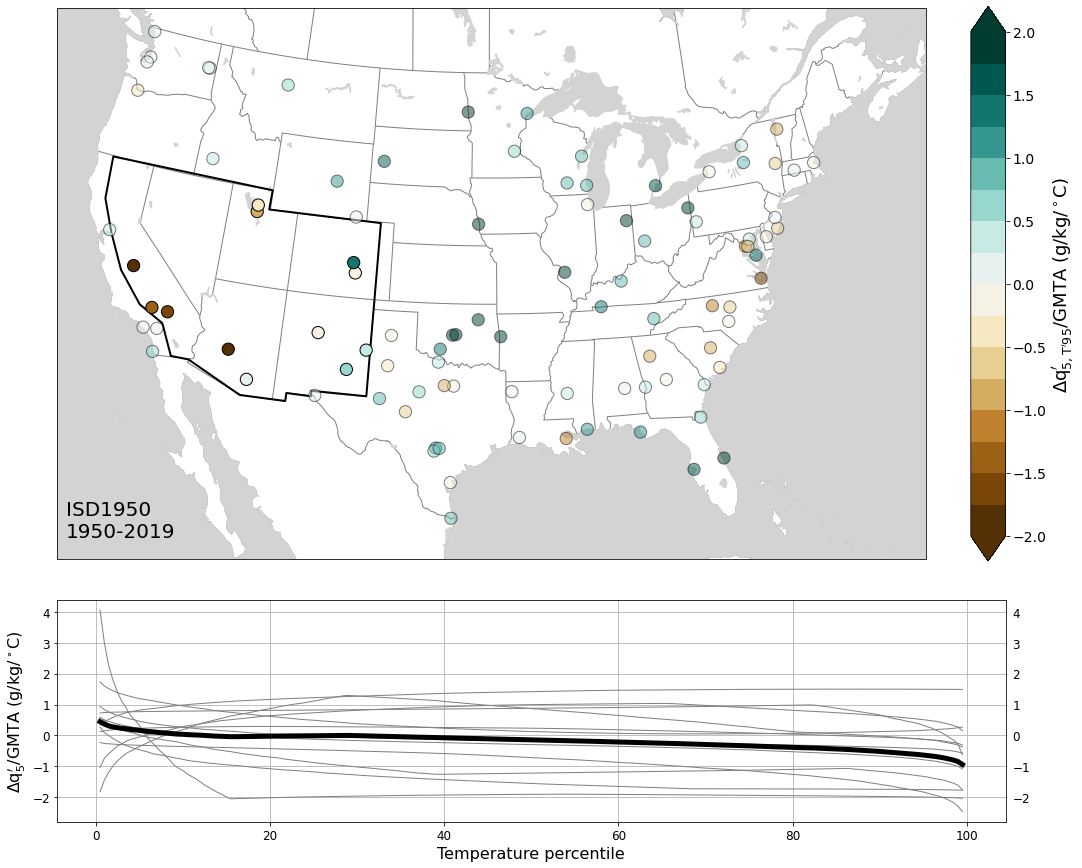

In [21]:
# ISD 1950
G_range = (gmt[gmt.index==2019].values - gmt[gmt.index==1950].values).flatten()[0]

meta_name = '%s/western_meta_ISD_%04d_%04d_month_%i-%i.csv' % (fdir, 1950, end_year, start_month, end_month)
western_meta_1950 = pd.read_csv(meta_name)
d = distance_matrix(np.vstack((western_meta_1950.lon, western_meta_1950.lat)).T, 
                    np.vstack((western_meta_1950.lon, western_meta_1950.lat)).T)

# for each station, weight by (0.5d1 + 0.5d2)**2
# approximating circle where radius is average of two closest stations
d[d==0] = np.nan
weights = np.array([((np.sort(d[ct, :])[:1])) for ct in range(len(western_meta_1950))])

western_meta_1950 = western_meta_1950.assign(area_weights=weights)
    
temperature_percentiles = np.arange(0.5, 100, 0.5)

ds = np.load(ISD1950_fit)
lats = ds['lats']
lons = ds['lons']
delta_H = ds['delta_H']
s0_H = ds['s0_H']
rho = ds['rho']

this_q = 0.05
this_T = 95

# trend per 1 deg GMTA
to_plot = (1/G_range)*(delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())

fig = plt.figure(figsize=(17, 15))
widths = [10, 0.4]
heights = [2.5, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, 
                        width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

# Add the map and set the extent
ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_map.set_extent(extent)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.LAKES, color='lightgray')
ax_map.add_feature(cfeature.LAND, color='white')
ax_map.add_feature(cfeature.OCEAN, color='lightgray', zorder=2)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=0)
ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=0)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=0)
ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=2)

cmap = plt.cm.BrBG
bounds = np.arange(-2, 2.1, 0.25)
norm = colors.BoundaryNorm(bounds, cmap.N)

# Pull out Western stations only
in_west = np.array([interior_west_shapely.contains(Point(this_lon, this_lat)) 
           for (this_lat, this_lon) in zip(lats, lons)])

sc = ax_map.scatter(lons[in_west],
                lats[in_west],
                c=to_plot[in_west],
                transform=ccrs.PlateCarree(),
                s=150,
                cmap=cmap,
                norm=norm,
                alpha=1,
                zorder=3,
                edgecolor='k')

ax_map.scatter(lons[~in_west],
                lats[~in_west],
                c=to_plot[~in_west],
                transform=ccrs.PlateCarree(),
                s=150,
                cmap=cmap,
                norm=norm,
                alpha=0.5,
                zorder=3,
                edgecolor='k')

ax_map.set_title('')
ax_map.text(0.01, 0.04, 'ISD1950\n1950-2019', transform=ax_map.transAxes, fontsize=20)

cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 

cb.set_label(r'$\Delta$q$^\prime_\mathrm{%d, T^\prime%d}$/GMTA (g/kg/$^\circ$C)' % (int(100*this_q), this_T),
             fontsize=18)
ax_ts = fig.add_subplot(spec[1, :])
# ax_ts.text(0.01, 0.07, '(b)', transform=ax_ts.transAxes, fontsize=20)

lon_west = np.round(lons[in_west], 3)
lat_west = np.round(lats[in_west], 3)
western_meta_1950 = western_meta_1950.assign(lat=np.round(western_meta_1950.lat, 3))
western_meta_1950 = western_meta_1950.assign(lon=np.round(western_meta_1950.lon, 3))
weights = np.empty((len(lon_west), ))
for kk in range(len(lon_west)):
    idx = np.where((western_meta_1950.lat == lat_west[kk]) & 
                   (western_meta_1950.lon == lon_west[kk]))[0][0]
    weights[kk] = western_meta_1950.loc[idx, 'area_weights']

all_vals = 1/G_range*delta_H[:, qs==this_q, in_west].squeeze()
all_vals_avg = np.sum(all_vals*weights[np.newaxis, :], axis=-1)/np.sum(weights)

ax_ts.plot(temperature_percentiles, all_vals, lw=1, c='gray')
ax_ts.plot(temperature_percentiles, all_vals_avg, '-k', lw=5)
ax_ts.tick_params(labelsize=12)
ax_ts.set_xlabel('Temperature percentile', fontsize=16)
ax_ts.set_ylabel(r'$\Delta$q$^\prime_{%d}$/GMTA (g/kg/$^\circ$C)' % int(100*this_q), fontsize=16)
ax_ts.grid()

ax_ts.tick_params(labelright=True)


plt.savefig('%s/supp_fig_ISD1950_map.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 7: a la Fig 2, with ERA5 data

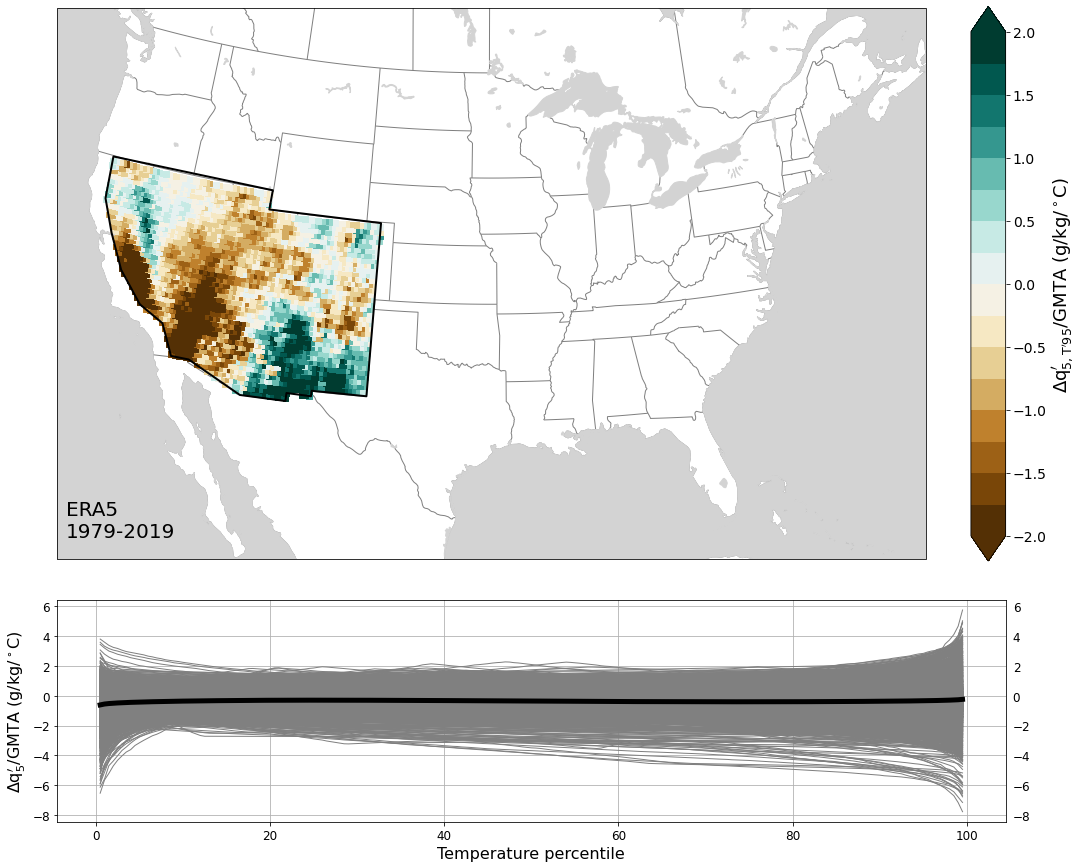

In [22]:
# ERA5
G_range = (gmt[gmt.index==2019].values - gmt[gmt.index==1979].values).flatten()[0]

ds = np.load(ERA5_fit)
lats = ds['lats']
lons = ds['lons']
delta_H = ds['delta_H']

this_q = 0.05
this_T = 95

# trend per 1 deg GMTA
to_plot = (1/G_range)*(delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())

fig = plt.figure(figsize=(17, 15))
widths = [10, 0.4]
heights = [2.5, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, 
                        width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

# Add the map and set the extent
ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_map.set_extent(extent)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.LAKES, color='lightgray')
ax_map.add_feature(cfeature.LAND, color='white')
ax_map.add_feature(cfeature.OCEAN, color='lightgray', zorder=2)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=0)
ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=0)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=0)
ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=2, zorder=3)

cmap = plt.cm.BrBG
bounds = np.arange(-2, 2.1, 0.25)
norm = colors.BoundaryNorm(bounds, cmap.N)

sc = ax_map.scatter(lons, 
                    lats,
                    c=to_plot,
                    transform=ccrs.PlateCarree(),
                    s=30,
                    cmap=cmap,
                    norm=norm,
                    alpha=1,
                    zorder=2,
                    marker='s')


ax_map.set_title('')
ax_map.text(0.01, 0.04, 'ERA5\n1979-2019', transform=ax_map.transAxes, fontsize=20)

cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 

cb.set_label(r'$\Delta$q$^\prime_\mathrm{%d, T^\prime%d}$/GMTA (g/kg/$^\circ$C)' % (int(100*this_q), this_T),
             fontsize=18)
ax_ts = fig.add_subplot(spec[1, :])
# ax_ts.text(0.01, 0.07, '(b)', transform=ax_ts.transAxes, fontsize=20)

weights = np.cos(np.deg2rad(lats))
all_vals = 1/G_range*delta_H[:, qs==this_q, :].squeeze()
all_vals_avg = np.sum(all_vals*weights[np.newaxis, :], axis=-1)/np.sum(weights)

ax_ts.plot(temperature_percentiles, all_vals, lw=1, c='gray')
ax_ts.plot(temperature_percentiles, all_vals_avg, '-k', lw=5)
ax_ts.tick_params(labelsize=12)
ax_ts.set_xlabel('Temperature percentile', fontsize=16)
ax_ts.set_ylabel(r'$\Delta$q$^\prime_{%d}$/GMTA (g/kg/$^\circ$C)' % int(100*this_q), fontsize=16)
ax_ts.grid()

ax_ts.tick_params(labelright=True)


plt.savefig('%s/supp_fig_ERA5_map.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 8: a la Fig 2, but with JRA55 data

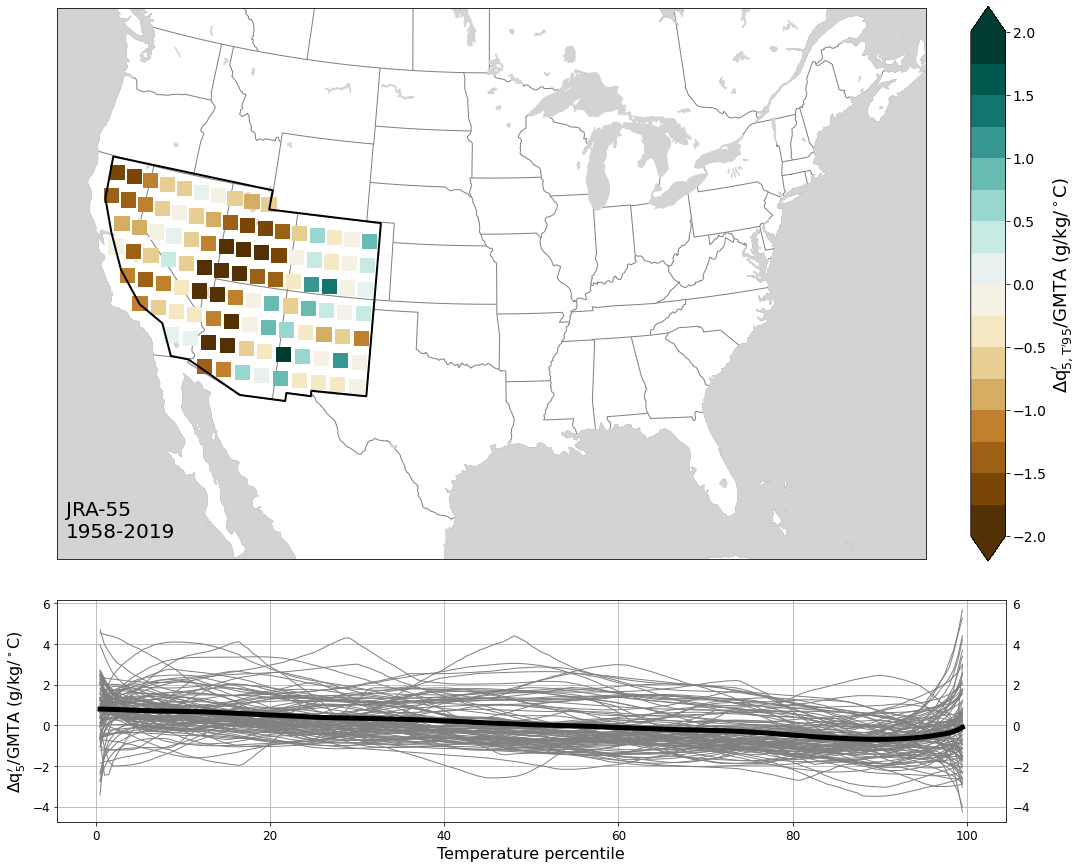

In [23]:
# JRA55
G_range = (gmt[gmt.index==2019].values - gmt[gmt.index==1958].values).flatten()[0]

ds = np.load(JRA55_fit)
lats = ds['lats']
lons = ds['lons']
delta_H = ds['delta_H']
delta_H *= 1000  # change from kg/kg to g/kg

this_q = 0.05
this_T = 95

# trend per 1 deg GMTA
to_plot = (1/G_range)*(delta_H[temperature_percentiles==this_T, qs==this_q, :].squeeze())

fig = plt.figure(figsize=(17, 15))
widths = [10, 0.4]
heights = [2.5, 1]
spec = fig.add_gridspec(ncols=2, nrows=2, 
                        width_ratios=widths, height_ratios=heights)

spec.update(wspace=0.1, hspace=0.1)

# Set Projection of Data
datacrs = ccrs.PlateCarree()

# Set Projection of Plot
plotcrs = ccrs.AlbersEqualArea(central_lon, central_lat)

# Add the map and set the extent
ax_map = fig.add_subplot(spec[0, 0], projection=plotcrs)
ax_map.set_extent(extent)

states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

ax_map.add_feature(cfeature.LAKES, color='lightgray')
ax_map.add_feature(cfeature.LAND, color='white')
ax_map.add_feature(cfeature.OCEAN, color='lightgray', zorder=2)
ax_map.add_feature(cfeature.BORDERS, edgecolor='gray', zorder=0)
ax_map.add_feature(cfeature.COASTLINE, edgecolor='gray', zorder=0)
ax_map.add_feature(states_provinces, edgecolor='gray', zorder=0)
ax_map.add_geometries(interior_west['geometry'], crs=ccrs.PlateCarree(), 
                      facecolor='none', edgecolor='black', linewidth=2, zorder=3)

cmap = plt.cm.BrBG
bounds = np.arange(-2, 2.1, 0.25)
norm = colors.BoundaryNorm(bounds, cmap.N)

sc = ax_map.scatter(lons, 
                    lats,
                    c=to_plot,
                    transform=ccrs.PlateCarree(),
                    s=200,
                    cmap=cmap,
                    norm=norm,
                    alpha=1,
                    zorder=2,
                    marker='s')


ax_map.set_title('')
ax_map.text(0.01, 0.04, 'JRA-55\n1958-2019', transform=ax_map.transAxes, fontsize=20)

cax = fig.add_subplot(spec[0, 1])
cb = plt.colorbar(sc, cax=cax, orientation='vertical', extend='both')
cb.ax.tick_params(labelsize=14) 

cb.set_label(r'$\Delta$q$^\prime_\mathrm{%d, T^\prime%d}$/GMTA (g/kg/$^\circ$C)' % (int(100*this_q), this_T),
             fontsize=18)
ax_ts = fig.add_subplot(spec[1, :])
# ax_ts.text(0.01, 0.07, '(b)', transform=ax_ts.transAxes, fontsize=20)

weights = np.cos(np.deg2rad(lats))
all_vals = 1/G_range*delta_H[:, qs==this_q, :].squeeze()
all_vals_avg = np.sum(all_vals*weights[np.newaxis, :], axis=-1)/np.sum(weights)

ax_ts.plot(temperature_percentiles, all_vals, lw=1, c='gray')
ax_ts.plot(temperature_percentiles, all_vals_avg, '-k', lw=5)
ax_ts.tick_params(labelsize=12)
ax_ts.set_xlabel('Temperature percentile', fontsize=16)
ax_ts.set_ylabel(r'$\Delta$q$^\prime_{%d}$/GMTA (g/kg/$^\circ$C)' % int(100*this_q), fontsize=16)
ax_ts.grid()

ax_ts.tick_params(labelright=True)


plt.savefig('%s/supp_fig_JRA55_map.pdf' % figdir, bbox_inches='tight')

### Supplementary figure 9: show amplification index with ISD1973 using more and less extreme cutoffs

In [24]:
fit_data_ISD1973 = '%s/ISD_US_map_data_trend_GMT_1973_2019_month_7-9.npz' % fdir
   
amplification_normal = utils.calculate_amplification_index2(western_df.copy(), western_meta.copy(),
                                                            90, 5, 'year', 
                                                            fit_data_ISD1973, qs, 0.1)

amplification_extreme = utils.calculate_amplification_index2(western_df.copy(), western_meta.copy(),
                                                             97.5, 2.5, 'year', 
                                                             fit_data_ISD1973, qs, 0.05)

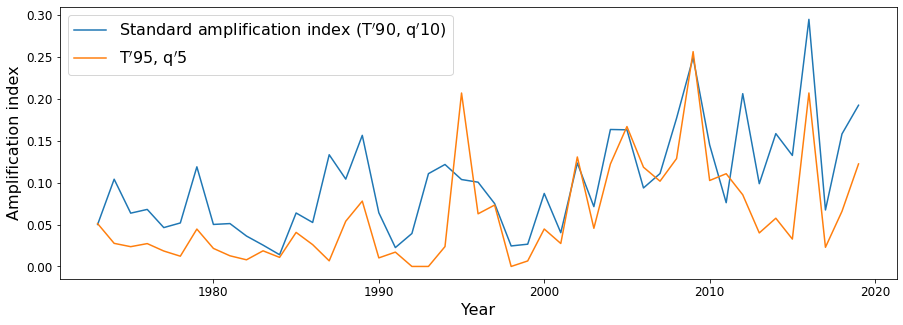

In [25]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(amplification_normal, label='Standard amplification index (T$^\prime$90, q$^\prime$10)')
ax.plot(amplification_extreme, label='T$^\prime$95, q$^\prime$5')
ax.legend(fontsize=16)
ax.set_xlabel('Year', fontsize=16)
ax.set_ylabel('Amplification index', fontsize=16)
ax.tick_params(labelsize=12)

plt.savefig('%s/supp_fig_compare_indices.pdf' % figdir, bbox_inches='tight')